In [83]:
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from planet import planet

In [84]:
# Function to split real and imaginary part of complex data into individual element of an array
def split_complex_data(data):
    split_data = np.zeros([data.shape[0],2*data.shape[1]])
    for i in range(data.shape[1]):
        split_data[:,2*i] = data[:,i].real
        split_data[:,2*i+1] = data[:,i].imag
    return split_data

# Function to split testing data according the type of tissue
def split_t2_tissues(data):
    csf_test = [] # T2 = 1.99
    gm_test = []  # T2 = 0.1
    wm_test = [] # T2 = 0.08

    for i in range(len(data)):
        if gt_test[i] == 1.99:
            csf_test.append(data[i,:])

        if gt_test[i] == 0.1:
            gm_test.append(data[i,:])
        
        if gt_test[i] == 0.08:
            wm_test.append(data[i,:])

    csf_test = np.asarray(csf_test)
    gm_test  = np.asarray(gm_test)
    wm_test  = np.asarray(wm_test)
    return csf_test, gm_test, wm_test

# Function for Monte Carlo Simulation
def monte_carlo(data):
    pdf = [] #empty list to store probability value
    result = 0

    # Neural network
    if data.shape[1] == 12:
        predicted_t2 = model.predict(data)

    # PLANET
    if data.shape[1] == 6:
        TR = 3e-3 # TR = relaxation time
        npcs = 6  # npcs = no. of phase cycles, 
        B0 = 3   # B0 =main magnetic field
        alpha = np.deg2rad(30) # alpha = flip angle
        pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
        _, _,predicted_t2 = planet(data, alpha=alpha, TR=TR, T1_guess=0.5, pcs=pcs, compute_df=False)
    
    for i in range(len(predicted_t2)):
        result = result + predicted_t2[i]
        pdf.append(result/(i+1)) #append result of each iteration to the empty list

    pdf  = np.asarray(pdf)
    return result/len(data), pdf

In [70]:
# Load voxel and ground truth t2 data
voxel_train = np.load('voxel_train.npy')
gt_train = np.load('gt_train.npy')

# Split training and test set, 1%
test_size = 100
voxel_test = voxel_train[-test_size:, :]
gt_test = gt_train[-test_size:,:]
voxel_train = voxel_train[:-test_size,:]
gt_train = gt_train[:-test_size,:]

print('Training data:', voxel_train[0,:])
print('Ground Truth T2:', gt_train[0,:])

Training data: [-0.14984257+0.00114747j -0.12661306-0.07165277j -0.05351978-0.08042419j
 -0.00538769+0.05144476j -0.07243941+0.11749424j -0.13104605+0.07412766j]
Ground Truth T2: [0.08]


In [85]:
new_voxel_train = split_complex_data(voxel_train)
print('Complex voxel data split into real and imaginary parts:', new_voxel_train[0,:])
new_voxel_test = split_complex_data(voxel_test)

Complex voxel data split into real and imaginary parts: [-0.14984257  0.00114747 -0.12661306 -0.07165277 -0.05351978 -0.08042419
 -0.00538769  0.05144476 -0.07243941  0.11749424 -0.13104605  0.07412766]


In [72]:
# Define the network structure
inputs = tf.keras.Input(shape=(12,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [73]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(new_voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
891/891 [==============================] - 4s 5ms/step - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/10
891/891 [==============================] - 4s 5ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0534 - val_mse: 0.0534
Epoch 3/10
891/891 [==============================] - 4s 5ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/10
891/891 [==============================] - 4s 5ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 6.8809e-04 - val_mse: 6.8809e-04
Epoch 5/10
891/891 [==============================] - 4s 4ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 5.9280e-04 - val_mse: 5.9280e-04
Epoch 6/10
891/891 [==============================] - 4s 4ms/step - loss: 5.3210e-04 - mse: 5.3210e-04 - val_loss: 4.8692e-04 - val_mse: 4.8692e-04
Epoch 7/10
891/891 [==============================] - 4s 4ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/10
891/891 [========================

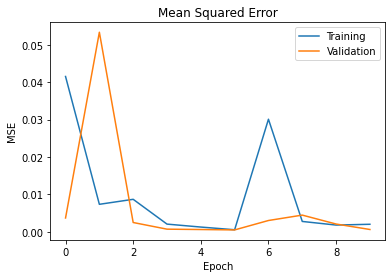

10/10 [==============================] - 0s 2ms/step - loss: 4.7329e-04 - mse: 4.7329e-04
Test MSE: 0.00047329318476840854


In [74]:
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(new_voxel_test, gt_test, batch_size=10)
print('Test MSE:',test_metric[1])

In [78]:
# Save or load trained model 
model.save('voxel_regression'); 
#model = tf.keras.models.load_model('voxel_regression')

INFO:tensorflow:Assets written to: voxel_regression\assets


In [86]:
# Split testing data into corresponding tissues
csf_test, gm_test, wm_test = split_t2_tissues(voxel_test)
new_csf_test, new_gm_test, new_wm_test = split_t2_tissues(new_voxel_test)

In [92]:
# PLANET : Monte Carlo
# mean_csf_t2_p, csf_pdf_p = monte_carlo(csf_test) 
# mean_gm_t2_p, gm_pdf_p = monte_carlo(gm_test)
# mean_wm_t2_p, wm_pdf_p = monte_carlo(wm_test)

Text(0, 0.5, 'Probability')

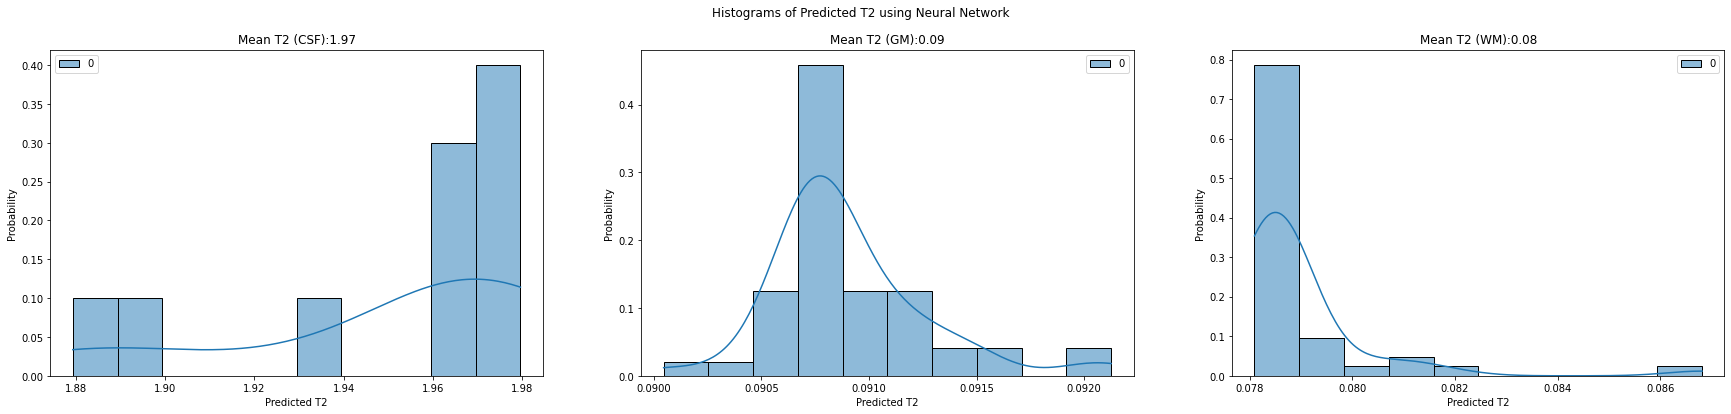

In [91]:
# Neural network : Monte Carlo
mean_csf_t2, csf_pdf = monte_carlo(new_csf_test) 
mean_gm_t2, gm_pdf = monte_carlo(new_gm_test)
mean_wm_t2, wm_pdf = monte_carlo(new_wm_test)

# Plotting of histograms 
bins = 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
fig.suptitle('Histograms of Predicted T2 using Neural Network')
sns.histplot(data=csf_pdf, bins=bins, stat='probability', kde=True, ax=ax1)
ax1.set_title('Mean T2 (CSF):%.2f' %mean_csf_t2)
ax1.set_xlabel('Predicted T2')
ax1.set_ylabel('Probability')

sns.histplot(data=gm_pdf, bins=bins, stat='probability', kde=True, ax=ax2)
ax2.set_title('Mean T2 (GM):%.2f' %mean_gm_t2)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')

sns.histplot(data=wm_pdf, bins=bins, stat='probability', kde=True, ax=ax3)
ax3.set_title('Mean T2 (WM):%.2f' %mean_wm_t2)
ax3.set_xlabel('Predicted T2')
ax3.set_ylabel('Probability')